# The purpose of this notebook is to classify the cell type of a ".hic" file into one of the following categories:
*   Uterine Cervix
*   Colon
*   Blood Cell
*   Skin Fibroblast
*   B Lymphocyte
*   Stem Cell
---
The core pipeline operates as follows:
1.   User uploads HIC file or uses default HIC file as an example
2.   HIC file is processsed (Computer Vision or TAD Frequency)
3.   Models predict based on processed HIC files

This colab script offers 2 classification types: Computer Vision and TAD Frequency.

1) The Computer Vision approach involves creating a heatmap from the given .hic file and using a Neural Network framework to classify the heatmap into one of the 6 cell types based on previously trained heatmaps.

2) The TAD Frequency approach utilizes a derivative of the one-hot encoding scheme coined as frequency encoding where insulation scores are used to quantify TAD strength as well as presence. Utilizing a Random Forest model trained on previously generated frequency encoding schemes, our pipeline is able to generate and classify the encoding scheme into one of the 6 cell types.


Quick Statistics:

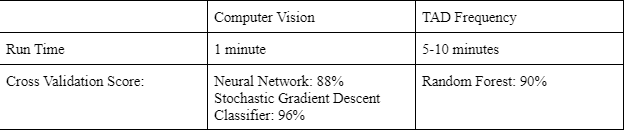







---


As you navigate this notebook, please follow the instructions underneath each subheading.



#Package Installation
Run cells and continue to next section.

These cells do not need to be opened.

In [10]:
!pip install --upgrade pip
!pip uninstall -y fanc
!pip uninstall -y pysam
!pip install Cython
!pip install pysam
!pip install fanc
!pip install texttable
!pip install opencv-python

Found existing installation: fanc 0.9.26
Uninstalling fanc-0.9.26:
  Successfully uninstalled fanc-0.9.26
Found existing installation: pysam 0.21.0
Uninstalling pysam-0.21.0:
  Successfully uninstalled pysam-0.21.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 16.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


  Created wheel for fanc: filename=fanc-0.9.27-cp39-cp39-macosx_10_9_x86_64.whl size=304797 sha256=c8f51198da67d0cc7709a3946cfd9d7706462d829a572601098d9affeb086d00
  Stored in directory: /Users/cyrilpillai/Library/Caches/pip/wheels/51/97/74/21d19f5c8639baae1865fbb48128f42c2ec098273f85110c43
Successfully built fanc


In [14]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pprint
import joblib
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog
from skimage.io import imread
from skimage.transform import rescale
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler, Normalizer
import skimage

import os
import subprocess
import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectFromModel
import pickle as pkl
from texttable import Texttable
import matplotlib.pyplot as plt
# import fanc.plotting as fancplot
from skimage import io, img_as_ubyte,color
import cv2
from numpy.linalg import norm
import numpy as np
import pandas as pd
# import fanc.plotting as fancplot
import plotly.express as px
import plotly.subplots as sp
import skimage
from skimage.util import crop
import plotly
from PIL import Image

#Package Installation Part 2
This will restart the runtime. After the runtime restarts, continue to "Loading the file".

These cells do not need to be opened.

In [15]:
!pip install -q condacolab
import condacolab
condacolab.install()

RuntimeError: This module must ONLY run as part of a Colab notebook!

# Loading the File

Please open these cells to enter your file URL.

The following steps should be followed in order to find an appropriate HIC file in the 4D Nucleome data portal


1.   Navigate to this [link](https://data.4dnucleome.org/browse/?experiments_in_set.biosample.tissue_organ_info.tissue_source=uterine+cervix&experiments_in_set.biosample.tissue_organ_info.tissue_source=definitive+endoderm&experiments_in_set.biosample.tissue_organ_info.tissue_source=stem+cell&experiments_in_set.biosample.tissue_organ_info.tissue_source=colon&experiments_in_set.biosample.tissue_organ_info.tissue_source=B-lymphocyte&experiments_in_set.biosample.tissue_organ_info.tissue_source=skin+fibroblast&experiments_in_set.experiment_type.display_title=in+situ+Hi-C&experiments_in_set.experiment_type.display_title=Dilution+Hi-C&experiments_in_set.experiment_type.display_title=Micro-C&experiments_in_set.experiment_type.display_title=DNase+Hi-C&experiments_in_set.experiment_type.display_title=TCC&experiments_in_set.experiment_type.experiment_category=Sequencing&experimentset_type=replicate&type=ExperimentSetReplicate)
2.  After navigating to this page select one of the rows (experiments) by clicking one of  the cells under the column "Title"
3.  The new page will be for the experiment selected. The bottom right of the new page will have another table with the section title "Processed Files". From this table select the file with the file type contact matrix (hic).
4. The new page should have a similair format to the one below. Paste the url into the following cell.

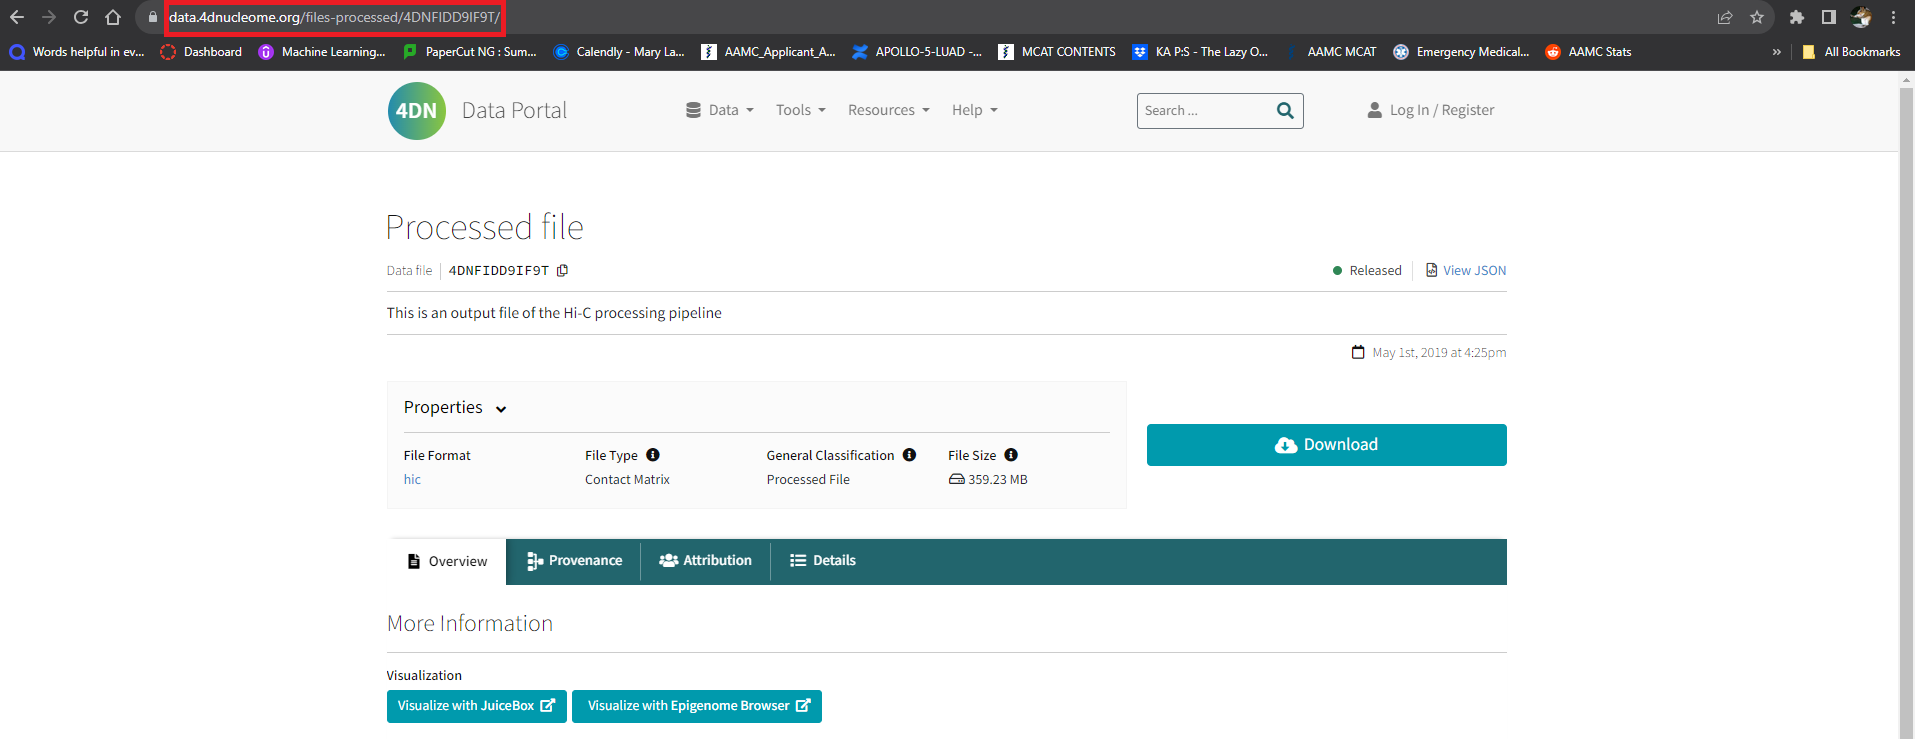

In [16]:
import ipywidgets as widgets
from IPython.display import display
#metadata_2023-12-04-00h-36m.tsv
# Create a text box widget for filename input
filename_text = widgets.Text(
    value='',
    placeholder='Enter link',
    description='Link to .hic:'
)

# Function to handle user input
def handle_submit(sender):
    print("Link entered:", filename_text.value)

# Assign the function handle_submit to be called when the user hits Enter after inputting the filename
filename_text.on_submit(handle_submit)

# Display the filename input widget
display(filename_text)

Text(value='', description='Link to .hic:', placeholder='Enter link')

Link entered: https://data.4dnucleome.org/files-processed/4DNFI7RGXYFY/


In [ ]:
from ipywidgets import FileUpload
from IPython.display import display
upload = FileUpload(accept='.hic', multiple=True)
display(upload)

FileUpload(value={}, accept='.txt', description='Upload', multiple=True)

In [19]:
url = filename_text.value
if "4D" not in url:
    raise ValueError("Invalid URL")
url = url[:url.rfind('/')]
hic_file_name = url.split("/")[-1] + ".hic"
url = url + "/@@download/" + hic_file_name
print(url)
!curl -L $url --output ./$hic_file_name --user KMXV2GYR:tvt6fgvpslvde3lu

path_to_hic = "./" + hic_file_name

https://data.4dnucleome.org/files-processed/4DNFI7RGXYFY/@@download/4DNFI7RGXYFY.hic
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   325  100   325    0     0    824      0 --:--:-- --:--:-- --:--:--   822
100 2035M  100 2035M    0     0  15.7M      0  0:02:09  0:02:09 --:--:-- 15.9M:00:03  0:02:46 17.3M16.2M15.4M      0  0:02:11  0:00:14  0:01:57 16.1M   0  15.3M      0  0:02:12  0:00:33  0:01:39 16.7M15.5M      0  0:02:10  0:01:13  0:00:57 15.6M  0  15.6M      0  0:02:10  0:01:15  0:00:55 16.3M  0  15.7M      0  0:02:09  0:02:01  0:00:08 15.5M


# Computer Vision Approach


##File Preprocessing For Computer Vision
These cells do not need to be opened, but do need to be run.

In [ ]:
#IMPORTANT PATHS
neural_model_path = '/content/drive/MyDrive/computerVision/pictures/models/neuralModel.pkl'
linear_model_path = '/content/drive/MyDrive/computerVision/pictures/models/linearModel3.pkl'
scaler_path = '/content/drive/MyDrive/computerVision/pictures/models/scaler.pkl'
!conda install -c conda-forge python-kaleido

In [ ]:
#Credit to  Patrick Steegstra https://kapernikov.com/tutorial-image-classification-with-scikit-learn/
from sklearn.base import BaseEstimator, TransformerMixin

class RGB2GrayTransformer(BaseEstimator, TransformerMixin):
    """
    Convert an array of RGB images to grayscale
    """

    def __init__(self):
        pass

    def fit(self, X, y=None):
        """returns itself"""
        return self

    def transform(self, X, y=None):
        """perform the transformation and return an array"""
        return np.array([skimage.color.rgb2gray(img) for img in X])


class HogTransformer(BaseEstimator, TransformerMixin):
    """
    Expects an array of 2d arrays (1 channel images)
    Calculates hog features for each img
    """

    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(8, 8),
                 cells_per_block=(3, 3), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):

        def local_hog(X):
            return hog(X,
                       orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block,
                       block_norm=self.block_norm)

        try: # parallel
            return np.array([local_hog(img) for img in X])
        except:
            return np.array([local_hog(img) for img in X])

In [ ]:
import pickle
with open(linear_model_path, 'rb') as file:
    linear_model = pickle.load(file)
with open(neural_model_path, 'rb') as file:
    neural_model = pickle.load(file)
with open(scaler_path, 'rb') as file:
    scalify = pickle.load(file)

In [ ]:
def displayMatrix(matrix,imageName):
  displayMatrix = np.log10(matrix)
  t = pd.DataFrame(displayMatrix)
  # t.columns = testRegions
  # t.index = testRegions
  upper_triangle_t = t.where(np.triu(np.ones(t.shape)).astype(bool))
  figure1 = px.imshow(upper_triangle_t)
  figure1.update_layout(showlegend=False)
  figure1.update_yaxes(visible=False, showticklabels=False)
  figure1.update_xaxes(visible=False, showticklabels=False)
  figure1.write_image(imageName.replace(".hic","IMAGE.png"),engine="auto")
  return imageName.replace(".hic","IMAGE.png")

In [ ]:
def process_files(file_path):
    print(f"Processing: {file_path}")
    hic = fanc.load(file_path+"@10mb")
    hicMatrix = hic.matrix()
    imageName = displayMatrix(hicMatrix,file_path)
    print(imageName)
    original = Image.open(imageName)
    width,height = original.size
    # Calculate the coordinates for cropping
    left = (width - 400) // 2
    top = (height - 400) // 2
    right = (width + 400) // 2
    bottom = (height + 400) // 2
    # Crop the image to create a 400x400 pixel square from the center
    cropped_image = original.crop((left, top, right, bottom))
    cropped_image.save(imageName)
    heatmap = io.imread(imageName)
    # heatmap = skimage.util.crop(heatmap,((150,150),(0,0),(10,10)))
    lower_white = np.array([200, 200, 200,255], dtype=np.uint8)
    upper_white = np.array([255,255,255,255], dtype=np.uint8)
    mask = cv2.inRange(heatmap, lower_white, upper_white)
    mask = ~mask
    res = cv2.bitwise_and(heatmap, heatmap, mask=mask)
    heatmap_without_white_lines = heatmap.copy()
    heatmap_without_white_lines[mask == 0] = [0, 0, 0,255]
    heatmap_visual = img_as_ubyte(heatmap_without_white_lines)
    figure2 = px.imshow(heatmap_visual)
    figure2.update_yaxes(visible=False, showticklabels=False)
    figure2.update_xaxes(visible=False, showticklabels=False)
    figure2.write_image(imageName.replace("IMAGE.png","MASKED.png"),engine="auto")
    maskedName = imageName.replace("IMAGE.png","MASKED.png")
    maskedOriginal = Image.open(maskedName)
    width,height = maskedOriginal.size
    # Calculate the coordinates for cropping
    left = (width - 400) // 2
    top = (height - 400) // 2
    right = (width + 400) // 2
    bottom = (height + 400) // 2
    # Crop the image to create a 400x400 pixel square from the center
    cropped_image = maskedOriginal.crop((left, top, right, bottom))
    cropped_image.save(maskedName)

In [ ]:
import fanc
process_files(path_to_hic)


Processing: /content/4DNFIPXU7V25.hic


<ipython-input-10-13563b46e566>:2: RuntimeWarning: divide by zero encountered in log10
  displayMatrix = np.log10(matrix)


/content/4DNFIPXU7V25IMAGE.png


In [ ]:
newName = path_to_hic.replace(".hic","MASKED.png")
im = cv2.imread(newName)
# im = cv2.imread('/content/4DNFI3NN1U8TMASKED.png')
im = resize(im, (400, 400))
X = []
X.append((im))
grayify = RGB2GrayTransformer()
hogify = HogTransformer(
    pixels_per_cell=(14, 14),
    cells_per_block=(2,2),
    orientations=9,
    block_norm='L2-Hys'
)
X_train_gray = grayify.transform(X)
X_train_hog = hogify.transform(X_train_gray)
X_train_prepared = scalify.transform(X_train_hog)

##Test Computer Vision Models
In order to view model results the cells will need to be opened and then run.

In [ ]:
pred = linear_model.predict(X_train_prepared)
print(pred)

['UterineCervix']


In [ ]:
t = Texttable()
probs = neural_model.predict_proba(X_train_prepared)[0]
classes = neural_model.classes_

t.add_row(["Class", "Probability"])
for i in range(len(probs)):
    t.add_row([classes[i], str(round(probs[i]*100,2))+' %'])
print(t.draw())
# Add paragraphs in support
# Change upload widget

+----------------+-------------+
| Class          | Probability |
+----------------+-------------+
| BLymphocyte    | 0.01 %      |
+----------------+-------------+
| BloodCell      | 0.0 %       |
+----------------+-------------+
| Colon          | 0.01 %      |
+----------------+-------------+
| SkinFibroblast | 0.0 %       |
+----------------+-------------+
| StemCell       | 0.0 %       |
+----------------+-------------+
| UterineCervix  | 99.98 %     |
+----------------+-------------+


# TAD Frequency Approach

## File Preprocessing for TAD Frequency
These cells do not need to be opened, but do need to be run.
We ask for your patience in this particular step, as running this step can take up to 10 minutes.



In [ ]:
if not path_to_hic.endswith(".hic"):
    raise Exception("Please re-upload a .hic file in the 'File Entry' section")

NameError: ignored

In [5]:
!pip install natsort
!pip install IPython
!pip install -U scikit-learn
!cp -r /content/drive/MyDrive/TAD_Frequency_Encoding/user_files /content/
!chmod u+x /content/user_files/*.sh
!/content/user_files/startup.sh
!/content/user_files/hic_file_processor.sh $path_to_hic


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
bedtools is already the newest version (2.30.0+dfsg-2ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.

h1d one IS /content/4DNFIKCEWMIA.hic 100000 chr1 -o IS_chr1 --datatype rawhic --gt /content/user_files/hg38_genome_table.txt -n 1000

Start dump matrix from hic file
Finish dump
Calculating 1D metrics for one sample
loading data...
loading finished
Finished calculating
Saving...

h1d one IS /content/4DNFIKCEWMIA.hic 100000 chr2 -o IS_chr2 --datatype rawhic --gt /content/user_files/hg38_genome_table.txt -n 1000

Start dump matrix from hic file
Finish dump
Calculating 1D metrics for one sample
loading data...
loading finished
Finished calculating
Saving...

h1d one IS /content/4DNFIKCEWMIA.hic 100000 chr3 -o IS_chr3 --datatype rawhic --gt /content/user_files/hg38_genome_table.txt -n 1000

Start dump matrix from hic file
Finish dump
Calculating 1D metrics for one sa

In [ ]:
import os
import subprocess
import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectFromModel
import pickle as pkl
import joblib
from texttable import Texttable

In [ ]:
classifier = pkl.load(open('/content/user_files/finalized_model.pkl', 'rb'))

In [ ]:
dataset = pd.read_pickle("/content/user_files/final_data.pkl")

X = dataset.values

## Test TAD Frequency Models
In order to view model results the cells will need to be opened and then run.

In [ ]:
t = Texttable()

probs = classifier.predict_proba(X)[0]
classes = classifier.classes_

t.add_row(["Class", "Probability"])
for i in range(len(probs)):
    t.add_row([classes[i], str(round(probs[i]*100,2))+' %'])
print(t.draw())


NameError: ignored

In [ ]:
import requests

# Replace 'YOUR_ENCODE_API_KEY' with your actual API key if required
encode_api_key = 'YOUR_ENCODE_API_KEY'
hic_file_url = 'https://www.encodeproject.org/some_hic_file_url'  # Replace with your HIC file URL

headers = {
    'Authorization': f'Bearer {encode_api_key}',
    'Content-Type': 'application/json'
}

response = requests.get(hic_file_url, headers=headers)

if response.status_code == 200:
    # File downloaded successfully
    with open('downloaded_file.hic', 'wb') as f:
        f.write(response.content)
    print('File downloaded successfully.')
else:
    print(f'Failed to download file. Status code: {response.status_code}')
    print(f'Response content: {response.content}')
